# Trabalho V - Metropolis 2
### Gabriel Victor Carvalho Rocha - 2018054907

In [23]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np

In [24]:
@jit(nopython=True)
def estado_inicial(N):
    s = np.zeros(N, dtype=np.int16)
    for i in range(N):
        s[i] = np.sign(2 * np.random.random() - 1)
    return s

In [25]:
@jit(nopython=True)
def vizinhos(L, N):
    viz = np.zeros((N, 4), dtype = np.int16)
    for k in range(N):
        viz[k, 0] = k + 1
        if (k + 1) % L == 0: viz[k, 0] = k + 1 - L
        viz[k, 1] = k + L
        if k > (N - L - 1): viz[k, 1] = k + L - N
        viz[k, 2] = k - 1
        if k % L == 0: viz[k, 2] = k + L - 1
        viz[k, 3] = k - L
        if k < L: viz[k, 3] = k + N - L
    return viz

In [26]:
@jit(nopython=True)
def energia(s, viz, N):
    ener = 0
    for i in range(N):
        h = s[viz[i, 0]] + s[viz[i, 1]]
        ener -= s[i] * h
    ener = int((ener + 2 * N) / 4)
    return ener

In [27]:
@jit(nopython=True)
def expos(beta):
    ex = np.zeros(5, dtype=np.float32)
    ex[0] = np.exp(8.0 * beta)
    ex[1] = np.exp(4.0 * beta)
    ex[2] = 0.0
    ex[3] = np.exp(-4.0 * beta)
    ex[4] = np.exp(-8.0 * beta)
    return ex

In [28]:
@jit(nopython=True)
def passo(beta, s, viz, ener, mag):
    N = len(s)
    ex = expos(beta)
    for i in range(N):
        h = s[viz[i, 0]] + s[viz[i, 1]] + s[viz[i, 2]] + s[viz[i, 3]]
        de = int(s[i] * h * 0.5 + 2)
        if np.random.random() < ex[de]:
            ener += 2 * s[i] * h
            mag -= 2 * s[i]
            s[i] = -s[i]
    return ener, mag, s

In [29]:
@jit(nopython=True)
def calcula_cv(beta, N, ener, ener_2):
    return ((beta ** 2) / N) * (ener_2 - (ener ** 2))

In [30]:
@jit(nopython=True)
def calcula_susmag(beta, N, mag, mag_2):
    return ((beta ** 2) / N) * (mag_2 - (mag ** 2))

In [31]:
@jit(nopython=True)
def calcula_erro(media, caixas, num_caixas):
    soma = 0
    for i in range(num_caixas):
        soma += (media - caixas[i]) ** 2
    soma /= num_caixas * (num_caixas - 1)
    err = soma ** 0.5
    return err

In [32]:
@jit(nopython=True)
def gera_caixas(num_caixas, m, N, beta, ener_array, mag_array):
    c_ener = np.zeros(num_caixas)
    c_ener_2 = np.zeros(num_caixas)
    c_mag = np.zeros(num_caixas)
    c_mag_2 = np.zeros(num_caixas)
    c_cv = np.zeros(num_caixas)
    c_susmag = np.zeros(num_caixas)
    
    for i in range(num_caixas):
        soma_ener = soma_ener_2 = 0
        soma_mag = soma_mag_2 = 0
        soma_cv = soma_susmag = 0
        for j in range(i * m, (i + 1) * m - 1):
            soma_ener += ener_array[j]
            soma_ener_2 += ener_array[j] ** 2
            soma_mag += mag_array[j] 
            soma_mag_2 += mag_array[j] ** 2
            
        c_ener[i] = soma_ener / m
        c_ener_2[i] = soma_ener_2 / m
        c_mag[i] = soma_mag / m
        c_mag_2[i] = soma_mag_2 / m
        c_cv[i] = calcula_cv(beta, N, c_ener[i], c_ener_2[i])
        c_susmag[i] = calcula_susmag(beta, N, c_mag[i], c_mag_2[i])
        
    return c_ener, c_mag, c_cv, c_susmag

In [33]:
@jit(nopython=True)
def metropolis(T, L, s):
    N = L * L
    beta = 1 / T
    
    num_passos = 10 ** 6
    num_caixas = 10
    m = num_passos / num_caixas
    
    viz = vizinhos(L, N)
    
    if s == None: s = estado_inicial(N)
        
    ener = energia(s, viz, N)
    mag = abs(np.sum(s))
    
    for _ in range(0, 10 ** 5):
        ener, mag, s = passo(beta, s, viz, ener, mag)
        
    ener_array = np.zeros(10 ** 6, dtype=np.float64)
    mag_array = np.zeros(10 ** 6, dtype=np.float64)
    
    for i in range(0, 10 ** 6):
        ener, mag, s = passo(beta, s, viz, ener, mag)
        ener_array[i] = ener
        mag_array[i] = abs(mag)
    
   
    c_ener, c_mag, c_cv, c_susmag = gera_caixas(num_caixas, m, N, beta, ener_array, mag_array)
    
    ener_spin = np.mean(c_ener)
    mag_spin = np.mean(c_mag)
    cv = np.mean(c_cv)
    susmag = np.mean(c_susmag)
    
    erro_ener = calcula_erro(ener_spin, c_ener, num_caixas)
    erro_mag = calcula_erro(mag_spin, c_mag, num_caixas)
    erro_cv = calcula_erro(cv, c_cv, num_caixas)
    erro_susmag = calcula_erro(susmag, c_susmag, num_caixas)
    
    return s, ener_spin, mag_spin, cv, susmag, erro_ener, erro_mag, erro_cv, erro_susmag

In [34]:
temperaturas = np.arange(5, 0.75, -0.25)
tamanhos = [18, 24, 36]

In [42]:
def gera_grafico(x, y, titulo):
    plt.plot(x, y[18], label="18x18")
    plt.plot(x, y[24], label="24x24")
    plt.plot(x, y[36], label="36x36")
    plt.title(f"{titulo}")
    plt.legend()
    plt.show()

In [36]:
eners, mags, cvs, susmags = {}, {}, {}, {}
e_eners, e_mags, e_cvs, e_susmags = {}, {}, {}, {}

In [37]:
for L in tamanhos:
    s = None
    eners[L], mags[L], cvs[L], susmags[L] = [], [], [], []
    e_eners[L], e_mags[L], e_cvs[L], e_susmags[L] = [], [], [], []
    for T in temperaturas:
        s, ener_spin, mag_spin, cv, susmag, erro_ener, erro_mag, erro_cv, erro_susmag =  metropolis(T, L, s)
        eners[L].append(ener_spin)
        mags[L].append(mag_spin)
        cvs[L].append(cv)
        susmags[L].append(susmag)
        e_eners[L].append(erro_ener)
        e_mags[L].append(erro_mag)
        e_cvs[L].append(erro_cv)
        e_susmags[L].append(erro_susmag)

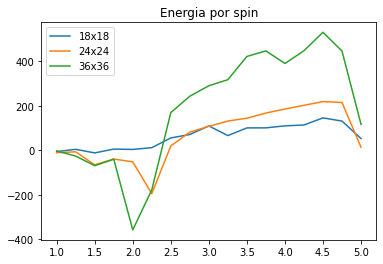

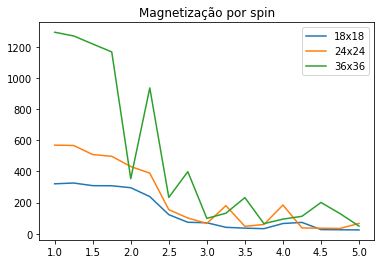

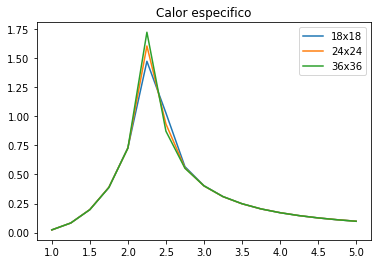

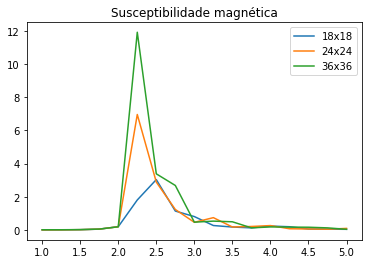

In [47]:
gera_grafico(temperaturas, eners, "Energia por spin")
gera_grafico(temperaturas, mags, "Magnetização por spin")
gera_grafico(temperaturas, cvs, "Calor especifico")
gera_grafico(temperaturas, susmags, "Susceptibilidade magnética")

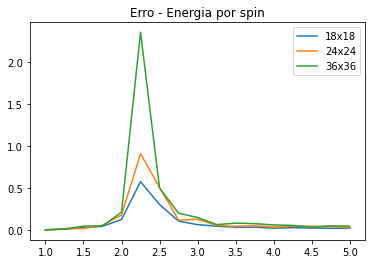

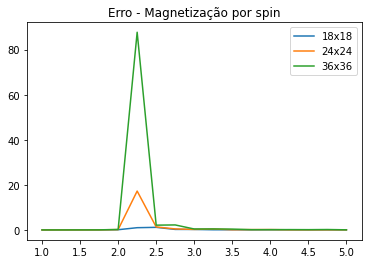

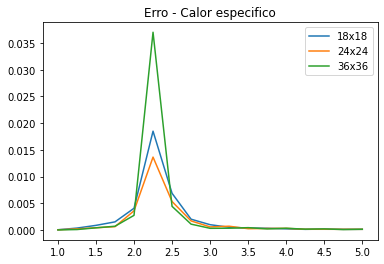

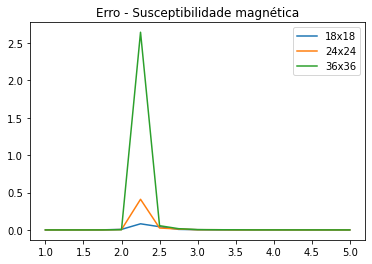

In [48]:
gera_grafico(temperaturas, e_eners, "Erro - Energia por spin")
gera_grafico(temperaturas, e_mags, "Erro - Magnetização por spin")
gera_grafico(temperaturas, e_cvs, "Erro - Calor especifico")
gera_grafico(temperaturas, e_susmags, "Erro - Susceptibilidade magnética")

Eu não entendi muito bem o que aconteceu no gráfico de Energia por spin, ele "segue" um padrão parecido mas não muito bem definido, talvez algum erro que não consegui encontrar. O mesmo ocorre com a magnetização média. Já o calor especifico ficou bem parecido com o apresentado no Wang Landau.
Os erros se encontram bem próximo de zero, porém entre as temperaturas 2.0 e 2.5 há um grande pico de erro em todas as grandezas.